# NYC Taxi Trip Dataset
### Author Information
Author: Ilung Pranata, PhD <br/>
Date created: 02/04/2018 <br/>
Last modified: 07/04/2018 <br/>
<br/><br/>
This document contains:
* Summary statistics for the two datasets
* Data Pre-processing (datasets merging, removing Outliers, longitude/latitude outlier removal)
* Sampling process
* Get NYC neighbor locations from coordinates
* Answer to Basic Question G (Top 10 Busiest Locations)
* Answer to Basic Question H (Trip with Highest Standard Deviation of Travel Time
* Answer to Basic Question I (Trip with the Most Consistent Fare)
* Answer to Open Question A (Using means to Estimate Fare & Time Taken)
* Answer to Open Question B (Building Model to Predict Tip & Fare Amount)
* Part Answer to Open Question C (Maximising Earning as Taxi Owner)
* Part Answer to Open Question D (Minimising Work Time while Retaining Average Wage)

In [2]:
import pandas as pd
import numpy as np
import itertools
import reverse_geocoder as rg
import matplotlib.pyplot as plt

from math import radians, cos, sin, asin, sqrt

# Load datasets

In [2]:
data_dir = '<< Insert_file_directory_here >>'
trip_data = pd.read_csv(data_dir + 'trip_data_4.csv', dtype={
    'medallion': np.str,
    'hack_license': np.str,
    'vendor_id': 'category',
    'rate_code': np.int16,
    'store_and_fwd_flag': 'category',
    'pickup_datetime': np.str,
    'dropoff_datetime': np.str,
    'passenger_count': np.int16,
    'trip_time_in_secs': np.int16,
    'trip_distance': np.int16,
    'pickup_longitude': np.float32,
    'pickup_latitude': np.float32,
    'dropoff_longitude': np.float32,
    'dropoff_latitude': np.float32}, header=0, parse_dates=[5, 6])
trip_fare = pd.read_csv(data_dir + 'trip_fare_4.csv', dtype={
    'medallion': np.str,
    'hack_license': np.str,
    'vendor_id': 'category',
    'pickup_datetime': np.str,
    'payment_type': 'category',
    'fare_amount': np.float32,
    'surcharge': np.float32,
    'mta_tax': np.float16,
    'tip_amount': np.float32,
    'tolls_amount': np.float32,
    'total_amount': np.float32}, parse_dates=[3], header=0)

C:\Users\i335425\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
## removing strips in columns text
trip_data.columns = trip_data.columns.str.strip()
trip_fare.columns = trip_fare.columns.str.strip()

# Summary Statistics

## Summary statistic for Trip_data

In [5]:
print(trip_data.shape)
print(trip_data.head(5))
print(trip_data.isnull().any())

(15100468, 14)
                          medallion                      hack_license  \
0  91F6EB84975BBC867E32CB113C7C2CD5  AD8751110E6292079EB10EB9481FE1A6   
1  EC34CD1B3797DFAFF3FE099BA87B6656  8FE6A4AEDF89B6B4E19D2377FD3FB7D7   
2  C1B9DA774DC2BBC6DE27CE994E7F44A0  E1B595FD55E4C82C1E213EB17438107A   
3  9BA84250355AB3FC031C9252D395BF8A  16BB0D96A0DCC853AEC7F55C8D6C71E0   
4  205A696DF62AD03C88DA8C5EC5248639  579C41EA5EC846F8B641A42F9EE3E855   

  vendor_id  rate_code store_and_fwd_flag     pickup_datetime  \
0       CMT          1                  N 2013-04-04 18:47:45   
1       CMT          1                  N 2013-04-05 07:08:34   
2       CMT          1                  N 2013-04-04 17:59:50   
3       CMT          1                  N 2013-04-04 18:12:01   
4       CMT          1                  N 2013-04-04 20:12:57   

     dropoff_datetime  passenger_count  trip_time_in_secs  trip_distance  \
0 2013-04-04 19:00:25                1                759            2.5   
1 2

In [7]:
trip_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
rate_code,15100468.0,1.033242,0.345117,0.0000,1.000000,1.000000,1.000000,210.0000
passenger_count,15100468.0,1.709030,1.385621,0.0000,1.000000,1.000000,2.000000,9.0000
trip_time_in_secs,15100468.0,746.608073,550.441401,0.0000,360.000000,600.000000,960.000000,10800.0000
trip_distance,15100468.0,2.862899,3.344187,0.0000,1.040000,1.780000,3.200000,100.0000
pickup_longitude,15100468.0,-72.734251,9.731627,-2323.4202,-73.992126,-73.981720,-73.966759,2228.7222
pickup_latitude,15100468.0,40.068606,6.956628,-3481.1411,40.735123,40.752808,40.767536,3210.3926
dropoff_longitude,15100322.0,-72.692572,9.858587,-2771.2900,-73.991432,-73.980072,-73.963623,2228.7456
dropoff_latitude,15100322.0,40.047948,6.977638,-3547.8977,40.734169,40.753326,40.768318,3577.1265


In [10]:
trip_data['store_and_fwd_flag'].value_counts()

N    7451841
Y     129970
Name: store_and_fwd_flag, dtype: int64

## Summary statistic for Trip_fare

In [8]:
print(trip_fare.shape)
print(trip_fare.head(5))
print(trip_fare.isnull().any())

(15100468, 11)
                          medallion                      hack_license  \
0  91F6EB84975BBC867E32CB113C7C2CD5  AD8751110E6292079EB10EB9481FE1A6   
1  EC34CD1B3797DFAFF3FE099BA87B6656  8FE6A4AEDF89B6B4E19D2377FD3FB7D7   
2  C1B9DA774DC2BBC6DE27CE994E7F44A0  E1B595FD55E4C82C1E213EB17438107A   
3  9BA84250355AB3FC031C9252D395BF8A  16BB0D96A0DCC853AEC7F55C8D6C71E0   
4  205A696DF62AD03C88DA8C5EC5248639  579C41EA5EC846F8B641A42F9EE3E855   

  vendor_id     pickup_datetime payment_type  fare_amount  surcharge  mta_tax  \
0       CMT 2013-04-04 18:47:45          CRD         11.0        1.0      0.5   
1       CMT 2013-04-05 07:08:34          CRD          8.5        0.0      0.5   
2       CMT 2013-04-04 17:59:50          CRD         16.5        1.0      0.5   
3       CMT 2013-04-04 18:12:01          CRD         10.0        1.0      0.5   
4       CMT 2013-04-04 20:12:57          CRD         15.0        0.5      0.5   

   tip_amount  tolls_amount  total_amount  
0        2.50  

In [9]:
trip_fare.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
fare_amount,15100468.0,12.274174,9.958736,2.5,6.5,9.5,14.0,500.0
surcharge,15100468.0,0.326690,0.367315,0.0,0.0,0.0,0.5,15.0
mta_tax,15100468.0,0.498321,0.028929,0.0,0.5,0.5,0.5,0.5
tip_amount,15100468.0,1.345662,2.131956,0.0,0.0,1.0,2.0,200.0
tolls_amount,15100468.0,0.244635,1.185930,0.0,0.0,0.0,0.0,20.0
total_amount,15100468.0,14.689481,11.940232,2.5,8.0,11.0,16.5,628.1


# EDA
Please refer to PowerBI files for all EDA graphs including answers to the basic questions for distribution

# Data Pre-processing

## Concatenate trip data and fare datasets

In [4]:
## Check if each row corresponds to each other in the two datasets
# if hack_license matches with hack_license
test = np.where(trip_data.iloc[:,1] == trip_fare.iloc[:,1], 'yes','no')
print(test[test == 'no'])

# if medallion matches with medallion
test = np.where(trip_data.iloc[:,0] == trip_fare.iloc[:,0], 'yes','no')
print(test[test == 'no'])

del test

[]
[]


In [4]:
## Each row of the two datasets seem to be match each other, so let's concat them
trip_all = pd.concat([trip_data, trip_fare.drop(['medallion', 'hack_license', 'vendor_id', 'pickup_datetime'], 
                                                axis=1)], axis=1)
print(trip_all.shape)
del trip_data
del trip_fare

(15100468, 21)


## Removing outliers

In [5]:
## removing 0 passenger records
trip_all = trip_all[trip_all['passenger_count'] > 0]
print(trip_all.shape)

(15100239, 21)


In [6]:
## removing 0 trip time records
trip_all = trip_all[trip_all['trip_time_in_secs'] > 0]
print(trip_all.shape)

(15062346, 21)


In [7]:
## removing 0 trip distance records
trip_all = trip_all[trip_all['trip_distance'] > 0]
print(trip_all.shape)

(14976785, 21)


## Processing longitude and latitude
Link to NYC Neighborhoods coordinates can be found here: https://data.cityofnewyork.us/City-Government/Neighborhood-Names-GIS/99bc-9p23

In [8]:
## loading NYC neighborhood coordinates
## Find the maximum and minimum longitude and latitude of NYC neighborhoods
nyc_neighbor = pd.read_csv(data_dir+'nyc_neighborhoods.csv', header=0)
print(nyc_neighbor.head(5))
print('Max longitude: %f' % max(nyc_neighbor['longitude']))
print('Min longitude: %f' % min(nyc_neighbor['longitude']))
print('Max latitude: %f' % max(nyc_neighbor['latitude']))
print('Min latitude: %f' % min(nyc_neighbor['latitude']))

   object_id  longitude   latitude neighborhoods borough
0          1 -73.847201  40.894705     Wakefield   Bronx
1          2 -73.829939  40.874294    Co-op City   Bronx
2          3 -73.827806  40.887556   Eastchester   Bronx
3          4 -73.905643  40.895437     Fieldston   Bronx
4          5 -73.912585  40.890834     Riverdale   Bronx
Max longitude: -73.708847
Min longitude: -74.246569
Max latitude: 40.908543
Min latitude: 40.505334


In [10]:
# See above for the longitude and latitude of NYC neighborhoods
# Let's do some tests on the pick-up locations within the NYC neighborhood area

# Test for pickup locations that near NYC longitude and latitude, 
test = trip_all[(trip_all['pickup_latitude'] >= 40.505334) & (trip_all['pickup_latitude'] <= 40.908543) & 
         (trip_all['pickup_longitude'] >= -74.246569) & (trip_all['pickup_longitude'] <= -73.708847)]
print('near NYC latitude/longitude: %d' % test.shape[0])

test = trip_all[(trip_all['pickup_longitude'] >= 40.505334) & (trip_all['pickup_longitude'] <= 40.908543) & 
         (trip_all['pickup_latitude'] >= -74.246569) & (trip_all['pickup_latitude'] <= -73.708847)]
print('inverse latitude/longitude: %d' % test.shape[0])

test = trip_all[(trip_all['pickup_longitude'] >= 73.708847) & (trip_all['pickup_longitude'] <= 74.246569)]
print('without negative numbers: %d' % test.shape[0])

del test

near NYC latitude/longitude: 14742023
inverse latitude/longitude: 211
without negative numbers: 0


In [9]:
# remove records which pickup locations are NOT within NYC Neighborhoods
trip_all = trip_all[(trip_all['pickup_latitude'] >= 40.505334) & (trip_all['pickup_latitude'] <= 40.908543) & 
         (trip_all['pickup_longitude'] >= -74.246569) & (trip_all['pickup_longitude'] <= -73.708847)]
print(trip_all.shape)

(14742023, 21)


In [12]:
# See above for the longitude and latitude of NYC neighborhoods
# Let's do some tests on the drop-off locations within the NYC neighborhood area

# Test for pickup locations that near NYC longitude and latitude, 
test = trip_all[(trip_all['dropoff_latitude'] >= 40.505334) & (trip_all['dropoff_latitude'] <= 40.908543) & 
         (trip_all['dropoff_longitude'] >= -74.246569) & (trip_all['dropoff_longitude'] <= -73.708847)]
print('near NYC latitude/longitude: %d' % test.shape[0])

test = trip_all[(trip_all['dropoff_longitude'] >= 40.505334) & (trip_all['dropoff_longitude'] <= 40.908543) & 
         (trip_all['dropoff_latitude'] >= -74.246569) & (trip_all['dropoff_latitude'] <= -73.708847)]
print('inverse latitude/longitude: %d' % test.shape[0])

test = trip_all[(trip_all['dropoff_longitude'] >= 73.708847) & (trip_all['dropoff_longitude'] <= 74.246569)]
print('without negative numbers: %d' % test.shape[0])

del test

near NYC latitude/longitude: 14726002
inverse latitude/longitude: 0
without negative numbers: 0


In [10]:
# remove records which dropoff locations are NOT within NYC Neighborhoods
trip_all = trip_all[(trip_all['dropoff_latitude'] >= 40.505334) & (trip_all['dropoff_latitude'] <= 40.908543) & 
         (trip_all['dropoff_longitude'] >= -74.246569) & (trip_all['dropoff_longitude'] <= -73.708847)]
print(trip_all.shape)

(14726002, 21)


# Sampling
Sampling is taken due to a limited computing power I have (a laptop with 16GB RAM). 10% sample of the population is taken (amount to 1,472,600 records). All questions after Basic Question F are answered based on sample data.

In [23]:
## let's check the stats of population
trip_all.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
rate_code,14726002.0,1.025439,0.295958,0.000000,1.000000,1.000000,1.000000,210.000000
passenger_count,14726002.0,1.713631,1.389747,1.000000,1.000000,1.000000,2.000000,9.000000
trip_time_in_secs,14726002.0,748.789875,545.889108,1.000000,363.000000,600.000000,960.000000,10800.000000
trip_distance,14726002.0,2.877417,3.312599,0.010000,1.070000,1.800000,3.200000,100.000000
pickup_longitude,14726002.0,-73.975442,0.034058,-74.240349,-73.992317,-73.982025,-73.967972,-73.708878
pickup_latitude,14726002.0,40.750990,0.026868,40.507389,40.736591,40.753448,40.767876,40.908543
dropoff_longitude,14726002.0,-73.974898,0.032766,-74.246284,-73.991615,-73.980499,-73.965118,-73.708870
dropoff_latitude,14726002.0,40.751381,0.030503,40.506039,40.735596,40.753956,40.768570,40.908535
fare_amount,14726002.0,12.161135,9.407520,2.500000,6.500000,9.500000,14.000000,500.000000
surcharge,14726002.0,0.327690,0.367364,0.000000,0.000000,0.000000,0.500000,15.000000


In [18]:
## taking 10% sample of the population
smp = trip_all.sample(frac=0.1, random_state=255, axis=0)

In [22]:
## let's check the stats for sample and compare it with population stats
smp.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
rate_code,1472600.0,1.025081,0.279703,0.000000,1.000000,1.000000,1.000000,210.000000
passenger_count,1472600.0,1.713533,1.389870,1.000000,1.000000,1.000000,2.000000,6.000000
trip_time_in_secs,1472600.0,747.973048,545.058888,1.000000,362.000000,600.000000,960.000000,10076.000000
trip_distance,1472600.0,2.871971,3.303559,0.010000,1.070000,1.800000,3.200000,100.000000
pickup_longitude,1472600.0,-73.975472,0.033967,-74.234375,-73.992310,-73.982010,-73.967979,-73.709251
pickup_latitude,1472600.0,40.751010,0.026839,40.508209,40.736656,40.753452,40.767895,40.908157
dropoff_longitude,1472600.0,-73.974915,0.032692,-74.241127,-73.991615,-73.980499,-73.965141,-73.708923
dropoff_latitude,1472600.0,40.751400,0.030530,40.506039,40.735622,40.753941,40.768589,40.908260
fare_amount,1472600.0,12.141963,9.377005,2.500000,6.500000,9.500000,14.000000,300.000000
surcharge,1472600.0,0.327341,0.367248,0.000000,0.000000,0.000000,0.500000,3.000000


In [29]:
## reset sample index
smp = smp.reset_index(drop=True)
print(smp.head(5))

                          medallion                      hack_license  \
0  8875F6D086DB5737DFC441485BC6D00A  3750BB44339F62BC0C15D6FCB669C65B   
1  A7E52F824BC1D8DC2535D4C6471E7899  753F8F7AF1E2F64CFD043E0B5A7FDDF4   
2  A786A56A2051ABE01B9B6668652D3C40  EF878C511BEC047F27C93BAFFE74674D   
3  59E0457233A3A674A61CE91130249CE1  5B48EF152BAE11454670500857E6F048   
4  F71AEBD7EDABA9D4157424BFC31D0477  E167CD9DC5D4400E145A63C97E78DA7F   

  vendor_id  rate_code store_and_fwd_flag     pickup_datetime  \
0       CMT          1                  N 2013-04-20 10:23:05   
1       VTS          1                NaN 2013-04-21 16:22:00   
2       CMT          1                  N 2013-04-02 19:01:31   
3       CMT          1                  N 2013-04-12 07:21:51   
4       VTS          1                NaN 2013-04-22 06:41:00   

     dropoff_datetime  passenger_count  trip_time_in_secs  trip_distance  \
0 2013-04-20 10:25:11                1                126           0.60   
1 2013-04-21 16:41

# Basic Question G: Top 10 busiest locations of the city

## Get neighbor name for pickup and dropoff coordinates
To find neighbors for pickup and dropoff coordinates, I must first find the distance of each record coordinate to the 299 NYC neighbors. A neighbor for pickup and dropoff is identified by the shortest distance of pickup/dropoff coordinate to it. NYC Neighbors coordinates are obtained from the link here: https://data.cityofnewyork.us/City-Government/Neighborhood-Names-GIS/99bc-9p23
<br/><br/>
There are two distance measures that can be used: Equirectangular and Harvesine distance. In this work, Equirectangular distance is used as it has lower computing requirements and covers the majority of distances in Earth. <br/>
Reference to distance formula: http://www.movable-type.co.uk/scripts/latlong.html

In [25]:
## equirectangular distance - much faster processing

def equirec_dist(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    R = 6371  ## radius of the earth in km
    x = (lon2 - lon1) * cos((lat2+lat1)/2 )
    y = lat2 - lat1
    return (R * sqrt( x*x + y*y ))
    
def haversine_dist(lon1, lat1, lon2, lat2):
    # convert coordinates to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # apply haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

def find_closest_neighbor(source_row, pickup_flag):
    """
    return neighbor whose has the lowest distance to the pickup/dropoff location
    """
    if source_row.name % 1000 == 0 :
        print('start index no: %d' % source_row.name)
        
    min_km = 100000
    closest_neighbor = ''
    for index,row in nyc_neighbor.iterrows():
        if pickup_flag == 'pickup':
            distance = equirec_dist(source_row['pickup_longitude'], source_row['pickup_latitude'], 
                                        row['longitude'], row['latitude'])
        else:
            distance = equirec_dist(source_row['dropoff_longitude'], source_row['dropoff_latitude'], 
                                        row['longitude'], row['latitude'])
        if distance < min_km:
            min_km = distance
            closest_neighbor = row['neighborhoods']
        
    return closest_neighbor

In [30]:
## find the neighbor location of pickup coordinate
smp['pickup_neighbor'] = smp.apply(find_closest_neighbor, pickup_flag='pickup', axis=1)
print(smp['pickup_neighbor'])

start index no: 0
start index no: 1000
start index no: 2000
start index no: 3000
start index no: 4000
start index no: 5000
start index no: 6000
start index no: 7000
start index no: 8000
start index no: 9000
start index no: 10000
start index no: 11000
start index no: 12000
start index no: 13000
start index no: 14000
start index no: 15000
start index no: 16000
start index no: 17000
start index no: 18000
start index no: 19000
start index no: 20000
start index no: 21000
start index no: 22000
start index no: 23000
start index no: 24000
start index no: 25000
start index no: 26000
start index no: 27000
start index no: 28000
start index no: 29000
start index no: 30000
start index no: 31000
start index no: 32000
start index no: 33000
start index no: 34000
start index no: 35000
start index no: 36000
start index no: 37000
start index no: 38000
start index no: 39000
start index no: 40000
start index no: 41000
start index no: 42000
start index no: 43000
start index no: 44000
start index no: 45000
s

start index no: 362000
start index no: 363000
start index no: 364000
start index no: 365000
start index no: 366000
start index no: 367000
start index no: 368000
start index no: 369000
start index no: 370000
start index no: 371000
start index no: 372000
start index no: 373000
start index no: 374000
start index no: 375000
start index no: 376000
start index no: 377000
start index no: 378000
start index no: 379000
start index no: 380000
start index no: 381000
start index no: 382000
start index no: 383000
start index no: 384000
start index no: 385000
start index no: 386000
start index no: 387000
start index no: 388000
start index no: 389000
start index no: 390000
start index no: 391000
start index no: 392000
start index no: 393000
start index no: 394000
start index no: 395000
start index no: 396000
start index no: 397000
start index no: 398000
start index no: 399000
start index no: 400000
start index no: 401000
start index no: 402000
start index no: 403000
start index no: 404000
start index

start index no: 719000
start index no: 720000
start index no: 721000
start index no: 722000
start index no: 723000
start index no: 724000
start index no: 725000
start index no: 726000
start index no: 727000
start index no: 728000
start index no: 729000
start index no: 730000
start index no: 731000
start index no: 732000
start index no: 733000
start index no: 734000
start index no: 735000
start index no: 736000
start index no: 737000
start index no: 738000
start index no: 739000
start index no: 740000
start index no: 741000
start index no: 742000
start index no: 743000
start index no: 744000
start index no: 745000
start index no: 746000
start index no: 747000
start index no: 748000
start index no: 749000
start index no: 750000
start index no: 751000
start index no: 752000
start index no: 753000
start index no: 754000
start index no: 755000
start index no: 756000
start index no: 757000
start index no: 758000
start index no: 759000
start index no: 760000
start index no: 761000
start index

start index no: 1073000
start index no: 1074000
start index no: 1075000
start index no: 1076000
start index no: 1077000
start index no: 1078000
start index no: 1079000
start index no: 1080000
start index no: 1081000
start index no: 1082000
start index no: 1083000
start index no: 1084000
start index no: 1085000
start index no: 1086000
start index no: 1087000
start index no: 1088000
start index no: 1089000
start index no: 1090000
start index no: 1091000
start index no: 1092000
start index no: 1093000
start index no: 1094000
start index no: 1095000
start index no: 1096000
start index no: 1097000
start index no: 1098000
start index no: 1099000
start index no: 1100000
start index no: 1101000
start index no: 1102000
start index no: 1103000
start index no: 1104000
start index no: 1105000
start index no: 1106000
start index no: 1107000
start index no: 1108000
start index no: 1109000
start index no: 1110000
start index no: 1111000
start index no: 1112000
start index no: 1113000
start index no: 

start index no: 1415000
start index no: 1416000
start index no: 1417000
start index no: 1418000
start index no: 1419000
start index no: 1420000
start index no: 1421000
start index no: 1422000
start index no: 1423000
start index no: 1424000
start index no: 1425000
start index no: 1426000
start index no: 1427000
start index no: 1428000
start index no: 1429000
start index no: 1430000
start index no: 1431000
start index no: 1432000
start index no: 1433000
start index no: 1434000
start index no: 1435000
start index no: 1436000
start index no: 1437000
start index no: 1438000
start index no: 1439000
start index no: 1440000
start index no: 1441000
start index no: 1442000
start index no: 1443000
start index no: 1444000
start index no: 1445000
start index no: 1446000
start index no: 1447000
start index no: 1448000
start index no: 1449000
start index no: 1450000
start index no: 1451000
start index no: 1452000
start index no: 1453000
start index no: 1454000
start index no: 1455000
start index no: 

In [30]:
## find the neighbor location of dropoff coordinate
smp['dropoff_neighbor'] = smp.apply(find_closest_neighbor, pickup_flag='dropoff',axis=1)
print(smp['dropoff_neighbor'])

start index no: 0
start index no: 1000
start index no: 2000
start index no: 3000
start index no: 4000
start index no: 5000
start index no: 6000
start index no: 7000
start index no: 8000
start index no: 9000
start index no: 10000
start index no: 11000
start index no: 12000
start index no: 13000
start index no: 14000
start index no: 15000
start index no: 16000
start index no: 17000
start index no: 18000
start index no: 19000
start index no: 20000
start index no: 21000
start index no: 22000
start index no: 23000
start index no: 24000
start index no: 25000
start index no: 26000
start index no: 27000
start index no: 28000
start index no: 29000
start index no: 30000
start index no: 31000
start index no: 32000
start index no: 33000
start index no: 34000
start index no: 35000
start index no: 36000
start index no: 37000
start index no: 38000
start index no: 39000
start index no: 40000
start index no: 41000
start index no: 42000
start index no: 43000
start index no: 44000
start index no: 45000
s

start index no: 362000
start index no: 363000
start index no: 364000
start index no: 365000
start index no: 366000
start index no: 367000
start index no: 368000
start index no: 369000
start index no: 370000
start index no: 371000
start index no: 372000
start index no: 373000
start index no: 374000
start index no: 375000
start index no: 376000
start index no: 377000
start index no: 378000
start index no: 379000
start index no: 380000
start index no: 381000
start index no: 382000
start index no: 383000
start index no: 384000
start index no: 385000
start index no: 386000
start index no: 387000
start index no: 388000
start index no: 389000
start index no: 390000
start index no: 391000
start index no: 392000
start index no: 393000
start index no: 394000
start index no: 395000
start index no: 396000
start index no: 397000
start index no: 398000
start index no: 399000
start index no: 400000
start index no: 401000
start index no: 402000
start index no: 403000
start index no: 404000
start index

start index no: 719000
start index no: 720000
start index no: 721000
start index no: 722000
start index no: 723000
start index no: 724000
start index no: 725000
start index no: 726000
start index no: 727000
start index no: 728000
start index no: 729000
start index no: 730000
start index no: 731000
start index no: 732000
start index no: 733000
start index no: 734000
start index no: 735000
start index no: 736000
start index no: 737000
start index no: 738000
start index no: 739000
start index no: 740000
start index no: 741000
start index no: 742000
start index no: 743000
start index no: 744000
start index no: 745000
start index no: 746000
start index no: 747000
start index no: 748000
start index no: 749000
start index no: 750000
start index no: 751000
start index no: 752000
start index no: 753000
start index no: 754000
start index no: 755000
start index no: 756000
start index no: 757000
start index no: 758000
start index no: 759000
start index no: 760000
start index no: 761000
start index

start index no: 1073000
start index no: 1074000
start index no: 1075000
start index no: 1076000
start index no: 1077000
start index no: 1078000
start index no: 1079000
start index no: 1080000
start index no: 1081000
start index no: 1082000
start index no: 1083000
start index no: 1084000
start index no: 1085000
start index no: 1086000
start index no: 1087000
start index no: 1088000
start index no: 1089000
start index no: 1090000
start index no: 1091000
start index no: 1092000
start index no: 1093000
start index no: 1094000
start index no: 1095000
start index no: 1096000
start index no: 1097000
start index no: 1098000
start index no: 1099000
start index no: 1100000
start index no: 1101000
start index no: 1102000
start index no: 1103000
start index no: 1104000
start index no: 1105000
start index no: 1106000
start index no: 1107000
start index no: 1108000
start index no: 1109000
start index no: 1110000
start index no: 1111000
start index no: 1112000
start index no: 1113000
start index no: 

start index no: 1415000
start index no: 1416000
start index no: 1417000
start index no: 1418000
start index no: 1419000
start index no: 1420000
start index no: 1421000
start index no: 1422000
start index no: 1423000
start index no: 1424000
start index no: 1425000
start index no: 1426000
start index no: 1427000
start index no: 1428000
start index no: 1429000
start index no: 1430000
start index no: 1431000
start index no: 1432000
start index no: 1433000
start index no: 1434000
start index no: 1435000
start index no: 1436000
start index no: 1437000
start index no: 1438000
start index no: 1439000
start index no: 1440000
start index no: 1441000
start index no: 1442000
start index no: 1443000
start index no: 1444000
start index no: 1445000
start index no: 1446000
start index no: 1447000
start index no: 1448000
start index no: 1449000
start index no: 1450000
start index no: 1451000
start index no: 1452000
start index no: 1453000
start index no: 1454000
start index no: 1455000
start index no: 

In [48]:
print(smp.head(5))

                          medallion                      hack_license  \
0  8875F6D086DB5737DFC441485BC6D00A  3750BB44339F62BC0C15D6FCB669C65B   
1  A7E52F824BC1D8DC2535D4C6471E7899  753F8F7AF1E2F64CFD043E0B5A7FDDF4   
2  A786A56A2051ABE01B9B6668652D3C40  EF878C511BEC047F27C93BAFFE74674D   
3  59E0457233A3A674A61CE91130249CE1  5B48EF152BAE11454670500857E6F048   
4  F71AEBD7EDABA9D4157424BFC31D0477  E167CD9DC5D4400E145A63C97E78DA7F   

  vendor_id  rate_code store_and_fwd_flag     pickup_datetime  \
0       CMT          1                  N 2013-04-20 10:23:05   
1       VTS          1                NaN 2013-04-21 16:22:00   
2       CMT          1                  N 2013-04-02 19:01:31   
3       CMT          1                  N 2013-04-12 07:21:51   
4       VTS          1                NaN 2013-04-22 06:41:00   

     dropoff_datetime  passenger_count  trip_time_in_secs  trip_distance  \
0 2013-04-20 10:25:11                1                126           0.60   
1 2013-04-21 16:41

## Find top 10 Busiest Pickup Locations

In [50]:
tmp = smp.groupby('pickup_neighbor')['medallion'].size().reset_index(name='cnt_top_pickup_neighbor')\
        .sort_values(by=['cnt_top_pickup_neighbor'], ascending=False)
tmp.head(10)

del tmp

,pickup_neighbor,cnt_top_pickup_neighbor
138,Midtown,130154
219,Sutton Place,97402
119,Lincoln Square,96130
139,Midtown South,92491
77,Flatiron,82503
46,Clinton,70747
39,Chelsea,66913
149,Murray Hill,58854
118,Lenox Hill,58789
229,Upper West Side,51168


## Find top 10 busiest dropoff locations

In [51]:
tmp = smp.groupby('dropoff_neighbor')['medallion'].size().reset_index(name='cnt_top_dropoff_neighbor')\
        .sort_values(by=['cnt_top_dropoff_neighbor'], ascending=False)
tmp.head(10)

del tmp

,dropoff_neighbor,cnt_top_dropoff_neighbor
164,Midtown,137893
258,Sutton Place,88370
143,Lincoln Square,88046
165,Midtown South,85703
92,Flatiron,71093
53,Clinton,66590
45,Chelsea,57916
141,Lenox Hill,56069
176,Murray Hill,55282
270,Upper West Side,53380


# Basic Question H: Trip with highest Standard Deviation of travel time

In [125]:
std_travel_time = smp[['pickup_neighbor', 'dropoff_neighbor', 'trip_time_in_secs']].groupby(['pickup_neighbor', 'dropoff_neighbor']).std().reset_index()
std_travel_time.columns = ['pickup_neighbor', 'dropoff_neighbor', 'stdev_travel_time']
std_travel_time.sort_values('stdev_travel_time', ascending=False)

,pickup_neighbor,dropoff_neighbor,stdev_travel_time
414,Battery Park City,Sunset Park,3356.917157
5157,Greenwich Village,Bayside,3224.406922
11346,Turtle Bay,East Tremont,2892.066735
832,Briarwood,Tudor City,2628.589403
1264,Bushwick,Maspeth,2388.606707
9938,South Ozone Park,Springfield Gardens,2288.185377
4455,Forest Hills,Midtown,2167.313650
9702,South Corona,Springfield Gardens,2163.746750
5889,Kew Gardens Hills,Clinton,2078.460969
12104,West Village,Kingsbridge,2050.609665


# Basic Question I: Trip with the most consistent fares
Consistent fare normally has zero or low standard deviation. As there are many trips with low occurrences and zero standard deviation, I take a trip with the highest number of occurrences as the answer.

In [289]:
std_fare = smp[['pickup_neighbor', 'dropoff_neighbor', 'medallion','fare_amount']].groupby(['pickup_neighbor', 'dropoff_neighbor'])\
        .agg({'medallion':'count','fare_amount':'mean'}).reset_index()
std_fare.columns = ['pickup_neighbor', 'dropoff_neighbor','total_trips','avg_fare']
std_fare['stdev_fare_amount'] = smp[['pickup_neighbor', 'dropoff_neighbor', 'fare_amount']]\
        .groupby(['pickup_neighbor', 'dropoff_neighbor']).std().reset_index()['fare_amount']
    
std_fare[std_fare['stdev_fare_amount'] == 0].sort_values(['total_trips'], ascending=False)

,pickup_neighbor,dropoff_neighbor,total_trips,avg_fare,stdev_fare_amount
6350,Lincoln Square,Springfield Gardens,252,52.0,0.0
8104,Murray Hill,Springfield Gardens,186,52.0,0.0
10218,Springfield Gardens,Manhattan Valley,146,52.0,0.0
11817,Upper West Side,Springfield Gardens,121,52.0,0.0
4996,Gramercy,South Ozone Park,113,52.0,0.0
1893,Chelsea,Springfield Gardens,100,52.0,0.0
7441,Midtown South,Brookville,99,52.0,0.0
11647,Upper East Side,South Ozone Park,89,52.0,0.0
4998,Gramercy,Springfield Gardens,85,52.0,0.0
12634,Yorkville,Springfield Gardens,83,52.0,0.0


In [118]:
## just double checking the results
smp[(smp['pickup_neighbor'] == 'Lincoln Square') & (smp['dropoff_neighbor'] == 'Springfield Gardens')]

,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,...,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,pickup_neighbor,dropoff_neighbor
10682,1CF2978577EAB95B50E142540CDCD304,41B04E84A85BB5BA6CE472138E780B37,VTS,2,NaN,2013-04-05 06:18:00,2013-04-05 06:59:00,1,2460,19.69,...,40.646233,CRD,52.0,0.0,0.5,10.40,0.00,62.90,Lincoln Square,Springfield Gardens
20245,437DDFC19FD0473B004FD259E07DE991,D0C4C1E9C4A50344713EA405B6D2C719,CMT,2,N,2013-04-25 12:39:58,2013-04-25 13:33:20,1,3203,18.30,...,40.645130,CRD,52.0,0.0,0.5,5.00,5.33,62.83,Lincoln Square,Springfield Gardens
25081,24B467177CF6D7126A13F3ED21438E90,CDA22191A3E0C98AEA67F4E6A4FDAD60,VTS,2,NaN,2013-04-01 15:44:00,2013-04-01 16:35:00,1,3060,18.67,...,40.644146,CRD,52.0,0.0,0.5,10.40,5.33,68.23,Lincoln Square,Springfield Gardens
28698,52296C2785890B4BAF74FBAB74141A5E,D1C13DD029180ACF9F77E0B14FAE02D1,VTS,2,NaN,2013-04-13 15:36:00,2013-04-13 16:22:00,1,2760,22.16,...,40.643826,CSH,52.0,0.0,0.5,0.00,5.33,57.83,Lincoln Square,Springfield Gardens
29085,55DD62A75B353FC19689C3CF99A76BBF,2C4EFFFC82D3F89CE5AC3FE357DFCBB1,VTS,2,NaN,2013-04-15 13:23:00,2013-04-15 14:10:00,1,2820,16.76,...,40.638767,CRD,52.0,0.0,0.5,10.40,0.00,62.90,Lincoln Square,Springfield Gardens
35703,3B8B4D7BBE18E91921FA6C7B82FECD4A,91B340ADD97DA4E1B974F515D38129B6,VTS,2,NaN,2013-04-09 18:29:00,2013-04-09 19:26:00,1,3420,18.50,...,40.646694,CRD,52.0,0.0,0.5,5.00,5.33,62.83,Lincoln Square,Springfield Gardens
45674,ABB5D04A3D40D9E8436D988AEBD2E3DB,C90A8DFA930ED79B3254FC334396FF1B,VTS,2,NaN,2013-04-05 08:49:00,2013-04-05 09:26:00,1,2220,16.70,...,40.644455,CSH,52.0,0.0,0.5,0.00,0.00,52.50,Lincoln Square,Springfield Gardens
52607,B75691B5B66F025E023F2D8920E92A29,93154A6C927C073625046501DB13791C,CMT,2,N,2013-04-04 16:21:47,2013-04-04 17:35:22,1,4414,21.20,...,40.638885,CRD,52.0,0.0,0.5,0.00,5.33,57.83,Lincoln Square,Springfield Gardens
53097,6F6DB4FE34210F8B7B47C01B136FFFC1,B16455EFCBBE46AB2B1BB7463F834FD7,VTS,2,NaN,2013-04-01 06:00:00,2013-04-01 06:33:00,1,1980,17.32,...,40.641129,CRD,52.0,0.0,0.5,10.40,0.00,62.90,Lincoln Square,Springfield Gardens
54099,33C5CA859B7EB35E11E63A777670DBEB,543FD943FA9F3E2291E73D3F8D4AAF6E,VTS,2,NaN,2013-04-30 07:30:00,2013-04-30 08:11:00,3,2460,22.01,...,40.644432,CSH,52.0,0.0,0.5,0.00,5.33,57.83,Lincoln Square,Springfield Gardens


# Open Question A: Use respective means as measures of central tendency to estimate fare, time taken.

In [127]:
print(std_travel_time.shape)
print(std_fare.shape)
std_trips = pd.merge(std_fare, std_travel_time, how='inner', left_on=['pickup_neighbor', 'dropoff_neighbor'], 
             right_on=['pickup_neighbor', 'dropoff_neighbor'])
print(std_trips.shape)

del std_travel_time
del std_fare

(12664, 3)
(12664, 4)
(12664, 5)


In [128]:
## surcharge 
std_trips['stdev_surcharge'] = smp[['pickup_neighbor', 'dropoff_neighbor', 'surcharge']]\
        .groupby(['pickup_neighbor', 'dropoff_neighbor']).std().reset_index()['surcharge']
    
## mta_tax
std_trips['stdev_tax'] = smp[['pickup_neighbor', 'dropoff_neighbor', 'mta_tax']]\
        .groupby(['pickup_neighbor', 'dropoff_neighbor']).std().reset_index()['mta_tax']
    
## tip_amount
std_trips['stdev_tip'] = smp[['pickup_neighbor', 'dropoff_neighbor', 'tip_amount']]\
        .groupby(['pickup_neighbor', 'dropoff_neighbor']).std().reset_index()['tip_amount']
    
## tolls_amount
std_trips['stdev_toll'] = smp[['pickup_neighbor', 'dropoff_neighbor', 'tolls_amount']]\
        .groupby(['pickup_neighbor', 'dropoff_neighbor']).std().reset_index()['tolls_amount']

## Trips with most consistent fare and time taken

In [130]:
std_trips[(std_trips['stdev_fare_amount'] == 0) & (std_trips['stdev_travel_time'] == 0)]

,pickup_neighbor,dropoff_neighbor,total_trips,stdev_fare_amount,stdev_travel_time,stdev_surcharge,stdev_tax,stdev_tip,stdev_toll
307,Battery Park City,Bensonhurst,2,0.0,0.0,0.000000,0.0,1.803122,0.0
558,Bensonhurst,Bath Beach,3,0.0,0.0,0.000000,0.0,0.000000,0.0
2442,Clinton,Schuylerville,2,0.0,0.0,0.000000,0.0,0.000000,0.0
5506,High Bridge,Riverdale,2,0.0,0.0,0.353553,0.0,0.000000,0.0


## Trips with the most consistent time taken and all amount types

In [131]:
std_trips[(std_trips['stdev_fare_amount'] == 0) & (std_trips['stdev_travel_time'] == 0) & (std_trips['stdev_travel_time'] == 0)
         & (std_trips['stdev_surcharge'] == 0) & (std_trips['stdev_tax'] == 0) & (std_trips['stdev_tip'] == 0) 
         & (std_trips['stdev_toll'] == 0)]

,pickup_neighbor,dropoff_neighbor,total_trips,stdev_fare_amount,stdev_travel_time,stdev_surcharge,stdev_tax,stdev_tip,stdev_toll
558,Bensonhurst,Bath Beach,3,0.0,0.0,0.0,0.0,0.0,0.0
2442,Clinton,Schuylerville,2,0.0,0.0,0.0,0.0,0.0,0.0


In [143]:
del std_trips

# Open Question B: Building Model to Predict Fare and Tip Amount
features used: pickup and dropoff coordinates, time of day and week.<br/>
Two approaches are used to create the model: Regression and Clustering Approaches. Note that models performance can be optimized further but was not done in this instance as the question only asks for if it is possible to create a model. 

In [134]:
smp.describe()

,rate_code,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
count,1.472600e+06,1.472600e+06,1.472600e+06,1.472600e+06,1.472600e+06,1.472600e+06,1.472600e+06,1.472600e+06,1.472600e+06,1.472600e+06,1.472600e+06,1.472600e+06,1.472600e+06,1.472600e+06
mean,1.025081e+00,1.713533e+00,7.479730e+02,2.871971e+00,-7.397547e+01,4.075101e+01,-7.397491e+01,4.075140e+01,1.214196e+01,3.273414e-01,4.989138e-01,1.327586e+00,2.380881e-01,1.453389e+01
std,2.797026e-01,1.389870e+00,5.450589e+02,3.303559e+00,3.396735e-02,2.683892e-02,3.269158e-02,3.052960e-02,9.377005e+00,3.672483e-01,2.327891e-02,2.035957e+00,1.165869e+00,1.130802e+01
min,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e-02,-7.423438e+01,4.050821e+01,-7.424113e+01,4.050604e+01,2.500000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00
25%,1.000000e+00,1.000000e+00,3.620000e+02,1.070000e+00,-7.399231e+01,4.073666e+01,-7.399161e+01,4.073562e+01,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,8.000000e+00
50%,1.000000e+00,1.000000e+00,6.000000e+02,1.800000e+00,-7.398201e+01,4.075345e+01,-7.398050e+01,4.075394e+01,9.500000e+00,0.000000e+00,5.000000e-01,1.000000e+00,0.000000e+00,1.100000e+01
75%,1.000000e+00,2.000000e+00,9.600000e+02,3.200000e+00,-7.396798e+01,4.076790e+01,-7.396514e+01,4.076859e+01,1.400000e+01,5.000000e-01,5.000000e-01,2.000000e+00,0.000000e+00,1.625000e+01
max,2.100000e+02,6.000000e+00,1.007600e+04,1.000000e+02,-7.370925e+01,4.090816e+01,-7.370892e+01,4.090826e+01,3.000000e+02,3.000000e+00,5.000000e-01,1.342500e+02,2.000000e+01,3.300000e+02


## Get required subset columns from the sample
Get a subest dataset with pickup & dropoff coordinates, time of day, week, tip_amount, fare_amount, pickup_neighbor and dropoff neighbor. Since coordinates were provided, neighbors could be obtained. As I had obtained neighbors in the sample preprocessing step above, I will not re-do this step.

In [3]:
data_dir = '<< Insert your directory here >>'
smp = pd.read_csv(data_dir+'processed_ds\\sample_all.csv', header=0, parse_dates=[5, 6])

In [4]:
cols = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude','fare_amount',
        'tip_amount','pickup_neighbor', 'dropoff_neighbor', 'pickup_datetime', 'dropoff_datetime']
df_train = smp[cols]
df_train['week'] = df_train['pickup_datetime'].dt.week
df_train['pickup_hour'] = df_train['pickup_datetime'].dt.hour
df_train['dropoff_hour'] = df_train['dropoff_datetime'].dt.hour
df_train.drop(['pickup_datetime', 'dropoff_datetime'], axis=1, inplace=True)

del cols

C:\Users\i335425\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\i335425\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\i335425\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

In [5]:
## Encode categorical variables with LabelEncoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_train['lbl_pickup_neighbor'] = le.fit_transform(df_train['pickup_neighbor'])
df_train['lbl_dropoff_neighbor'] = le.fit_transform(df_train['dropoff_neighbor'])

df_train.drop(['pickup_neighbor','dropoff_neighbor'], 1, inplace=True)

C:\Users\i335425\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\i335425\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\i335425\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set o

In [9]:
df_train.head(5)

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,tip_amount,week,pickup_hour,dropoff_hour,lbl_pickup_neighbor,lbl_dropoff_neighbor
0,-73.981926,40.783413,-73.975822,40.789577,4.0,0.90,16,10,10,229,270
1,-73.961197,40.756706,-73.983597,40.779591,14.0,2.80,16,16,16,219,143
2,-73.993301,40.731041,-74.011520,40.707848,9.0,0.00,14,19,19,95,90
3,-73.976303,40.755436,-74.009872,40.721905,11.5,1.50,15,7,7,138,264
4,-73.961288,40.765865,-73.952759,40.768166,5.0,1.25,17,6,6,118,141


## Regression Approach

### Regression model for Fare esitmation

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(df_train.drop(['fare_amount', 'tip_amount'], 1),df_train['fare_amount'],
                                                    test_size=0.33, random_state=255)

ss = StandardScaler(copy=True, with_mean=True, with_std=True)
X_train = ss.fit_transform(X_train)
X_test = ss.fit_transform(X_test)

model = LinearRegression(fit_intercept=True, normalize=True, n_jobs=3)
predictions = model.fit(X_train, y_train).predict(X_test)
print('MSE - Linear: %f' % mean_squared_error(y_test, predictions))
print('R2 - Linear: %f' % r2_score(y_test, predictions))

model = RandomForestRegressor(n_estimators=100, max_features='auto', max_depth=8, min_samples_split=2,
                              min_samples_leaf=1, random_state=255, n_jobs=3)
predictions = model.fit(X_train, y_train).predict(X_test)
print('MSE - RR: %f' % mean_squared_error(y_test, predictions))
print('R2 - RR: %f' % r2_score(y_test, predictions))

## use SVR to model -- very slow, require higher computation power
## model = SVR(C=1, kernel='rbf', gamma='auto')
## predictions = model.fit(X_train, y_train).predict(X_test)
## print('MSE - SVR: %f' % mean_squared_error(y_test, predictions))
## print('R2 - SVR: %f' % r2_score(y_test, predictions))

MSE - Linear: 57.761323
R2 - Linear: 0.341546
MSE - RR: 21.472632
R2 - RR: 0.755221


### Regression model for Tip estimation

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(df_train.drop(['fare_amount', 'tip_amount'], 1),df_train['tip_amount'],
                                                    test_size=0.33, random_state=255)

ss = StandardScaler(copy=True, with_mean=True, with_std=True)
X_train = ss.fit_transform(X_train)
X_test = ss.fit_transform(X_test)

model = LinearRegression(fit_intercept=True, normalize=True, n_jobs=3)
predictions = model.fit(X_train, y_train).predict(X_test)
print('MSE - Linear: %f' % mean_squared_error(y_test, predictions))
print('R2 - Linear: %f' % r2_score(y_test, predictions))

model = RandomForestRegressor(n_estimators=100, max_features='auto', max_depth=8, min_samples_split=2,
                              min_samples_leaf=1, random_state=255, n_jobs=3)
predictions = model.fit(X_train, y_train).predict(X_test)
print('MSE - RR: %f' % mean_squared_error(y_test, predictions))
print('R2 - RR: %f' % r2_score(y_test, predictions))

## use SVR to model -- very slow require higher computation power
## model = SVR(C=1, kernel='rbf', gamma='auto')
## predictions = model.fit(X_train, y_train).predict(X_test)
## print('MSE - SVR: %f' % mean_squared_error(y_test, predictions))
## print('R2 - SVR: %f' % r2_score(y_test, predictions))

MSE - Linear: 3.763145
R2 - Linear: 0.082312
MSE - RR: 3.084349
R2 - RR: 0.247844


## Clustering Approach

### Cluster Model for Tip

In [90]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

## splitting train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_train.drop(['tip_amount'], 1), df_train['tip_amount'],
                                                    test_size=0.33, random_state=255)

## store the fare amount so that it can be used later to cluster fare
y_train_fare = X_train['fare_amount']
y_test_fare = X_test['fare_amount']
X_train.drop('fare_amount', axis=1, inplace=True)
X_test.drop('fare_amount', axis=1, inplace=True)

## use elbow methods to find the best k
distorsions = []
for k in range(2, 20):
    model = KMeans(n_clusters=k, random_state=255)
    model.fit(X_train)
    distorsions.append(model.inertia_)


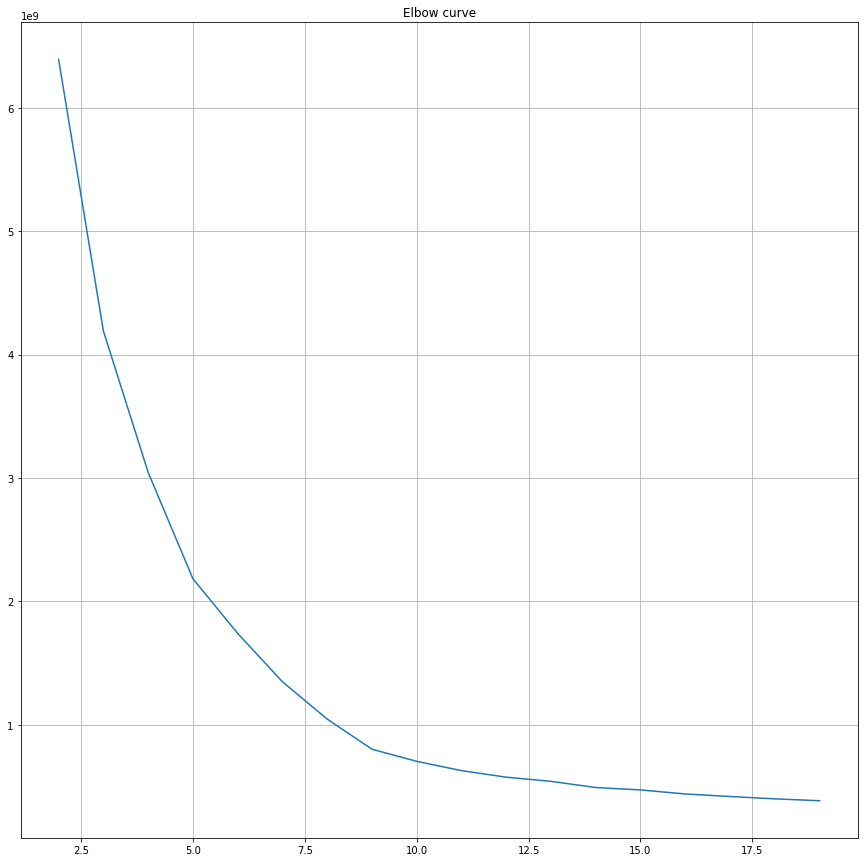

In [13]:
fig = plt.figure(figsize=(15, 15))
plt.plot(range(2, 20), distorsions)
plt.grid(True)
plt.title('Elbow curve')
plt.show()

It seems that cluster number 9 has a kink that we look for. Let's use k=9 for our cluster

In [91]:
model = KMeans(n_clusters=9, random_state=255)
model.fit(X_train)
print(model.labels_)

[0 5 0 ..., 8 5 5]


In [92]:
X_train['tip_amount'] = y_train
X_train['cluster_labels'] = model.labels_

cluster_tip_tbl = pd.DataFrame(columns=['cluster_labels','total_records','median_tip','avg_tip', 'stdev_tip'])
for i in range(0,8):
    tmp = X_train[X_train['cluster_labels'] == i].groupby('cluster_labels').agg({
        'pickup_longitude':'count',
        'tip_amount':['median', 'mean', 'std']
    }).reset_index()
    tmp.columns = tmp.columns.map("_".join)
    tmp.columns = cluster_tip_tbl.columns
    cluster_tip_tbl = pd.concat([cluster_tip_tbl, tmp], ignore_index=True)
    
print(cluster_tip_tbl)

  cluster_labels total_records  median_tip   avg_tip  stdev_tip
0              0        157672         0.0  1.032704   1.631908
1              1        131671         1.0  1.437500   2.181325
2              2        112084         0.9  1.187156   1.849026
3              3         75397         1.0  1.601564   2.312688
4              4         79173         0.0  1.166952   2.105165
5              5        142827         1.0  1.451006   2.089126
6              6        111893         1.0  1.421923   1.982424
7              7         68541         1.0  1.598851   2.285281


### Cluster Model for Fare
The number of K for fare amount will be the same as the tip amount as the training data between both is same.

In [93]:
X_train['fare_amount'] = y_train_fare

cluster_fare_tbl = pd.DataFrame(columns=['cluster_labels','total_records','median_fare','avg_fare', 'stdev_fare'])
for i in range(0,8):
    tmp = X_train[X_train['cluster_labels'] == i].groupby('cluster_labels').agg({
        'pickup_longitude':'count',
        'fare_amount':['median', 'mean', 'std']
    }).reset_index()
    tmp.columns = tmp.columns.map("_".join)
    tmp.columns = cluster_fare_tbl.columns
    cluster_fare_tbl = pd.concat([cluster_fare_tbl, tmp], ignore_index=True)
print(cluster_fare_tbl)

  cluster_labels total_records  median_fare   avg_fare  stdev_fare
0              0        157672          8.5   9.944174    6.971988
1              1        131671          9.0  12.381794    9.640082
2              2        112084          9.0  11.304295    8.586850
3              3         75397         10.5  14.306096   11.087282
4              4         79173          8.0  11.377836   10.846774
5              5        142827         10.0  12.785085    8.960159
6              6        111893         10.0  12.685615    8.356994
7              7         68541         10.5  14.111054   10.176897


### Predict fare and tip using modeled clusters, median tip and median fare

In [94]:
# get the cluster prediction
X_test['cluster_labels'] = model.predict(X_test)

## use median fare and tip of the clusters to predict

## TOO SLOW TO RUN
#fare=[]
#tip=[]
#for index, row in X_test.iterrows():
#    fare.append(cluster_fare_tbl[cluster_fare_tbl['cluster_labels'] == row['cluster_labels']]['median_fare'])
#    tip.append(cluster_fare_tbl[cluster_tip_tbl['cluster_labels'] == row['cluster_labels']]['median_tip'])

## FASTER METHOD
X_test = pd.merge(X_test, cluster_fare_tbl[['cluster_labels','median_fare']], how='inner', 
                  left_on='cluster_labels', right_on='cluster_labels')
X_test = pd.merge(X_test, cluster_tip_tbl[['cluster_labels','median_tip']], how='inner', 
                  left_on='cluster_labels', right_on='cluster_labels')
print(X_test)

        pickup_longitude  pickup_latitude  dropoff_longitude  \
0             -73.986542        40.745052         -73.977905   
1             -73.975388        40.761028         -73.985191   
2             -73.953285        40.767681         -73.990318   
3             -73.983658        40.755959         -73.982040   
4             -73.985748        40.767918         -73.983795   
5             -73.988174        40.718452         -73.951630   
6             -73.958046        40.713402         -73.950005   
7             -73.973976        40.751339         -73.976021   
8             -73.980598        40.764793         -73.969948   
9             -73.960777        40.769550         -73.980797   
10            -73.963615        40.765587         -73.981888   
11            -73.980507        40.753353         -73.993378   
12            -73.980843        40.759022         -73.939430   
13            -73.980141        40.749081         -73.976334   
14            -73.982712        40.76134

# Open Question C: Maximising earning as a taxi owner
The task below is just part of Answer to this question. All EDA graphs for answerring this question can be found in the PowerBI files.

## Getting top 10 earning (fare and tip amount) for each trip

In [287]:
smp['fare_tip_amount'] = smp['fare_amount'] + smp['tip_amount']

tmp = smp.groupby(['pickup_neighbor']).agg({'medallion':'count','fare_tip_amount':'sum'}).reset_index()
tmp.columns = ['pickup_neighbor','trip_count', 'sum_fare_tip_amount']
tmp['fare_tip_per_trip'] = tmp['sum_fare_tip_amount']/tmp['trip_count']

print(tmp[tmp['trip_count']>10000].sort_values('fare_tip_per_trip', ascending=False).head(10))

del tmp

         pickup_neighbor  trip_count  sum_fare_tip_amount  fare_tip_per_trip
209  Springfield Gardens       10837            541200.42          49.940059
62         East Elmhurst       29555           1014848.84          34.337636
75    Financial District       24085            431884.98          17.931699
7      Battery Park City       12664            221031.99          17.453568
223              Tribeca       14342            205284.06          14.313489
43          Civic Center       18436            261319.76          14.174428
142  Morningside Heights       13417            189081.80          14.092703
200                 Soho       18470            245084.57          13.269332
121         Little Italy       13878            183149.88          13.197138
156                 Noho       37690            496292.31          13.167745


# Open Question D: Minimising work time while retaining the average wages earned
The task below is just part of Answer to this question. All EDA graphs for answerring this question can be found in the PowerBI files.

## Dropoff neighbors and their pickup count for Midtown

In [271]:
tmp1 = smp.groupby('pickup_neighbor').size().reset_index(name='pickup_count')

tmp2 = smp[smp['pickup_neighbor'] == 'Midtown'].groupby('dropoff_neighbor').size().reset_index(name='dropoff_count')\
        .sort_values('dropoff_count', ascending=False)
    
tmp1 = pd.merge(tmp2,tmp1, how='inner', left_on='dropoff_neighbor', right_on='pickup_neighbor')
tmp1.drop('pickup_neighbor', axis=1, inplace=True)
tmp1.sort_values('pickup_count', ascending=False)

del tmp1
del tmp2

,dropoff_neighbor,dropoff_count,pickup_count
0,Midtown,14912,130154
3,Sutton Place,9066,97402
2,Lincoln Square,9921,96130
1,Midtown South,12688,92491
5,Flatiron,6657,82503
4,Clinton,8103,70747
8,Chelsea,4615,66913
6,Murray Hill,4928,58854
7,Lenox Hill,4690,58789
10,Upper West Side,4161,51168


## Pickup neighbors with average fare_tip and time in seconds

In [272]:
top_10_busiest = ['Midtown', 'Sutton Place', 'Lincoln Square', 'Midtown South', 'Flatiron', 'Clinton', 
                  'Chelsea', 'Murray Hill','Lenox Hill','Uper West Side']

std_fare = smp.groupby(['pickup_neighbor'])\
        .agg({'medallion':'count','fare_tip_amount':'mean'}).reset_index()
std_fare.columns = ['pickup_neighbor','total_trips','avg_fare_tip']

#std_fare = smp[smp['pickup_neighbor'].isin(top_10_busiest) & smp['dropoff_neighbor'].isin(top_10_busiest)]
#std_fare.drop('dropoff_neighbor',axis=1, inplace=True)

tmp = smp[['pickup_neighbor', 'fare_tip_amount']].groupby(['pickup_neighbor']).std().reset_index()
tmp.columns = ['pickup_neighbor','stdev_fare_tip']
std_fare = pd.merge(std_fare, tmp, how='inner', left_on=['pickup_neighbor'], right_on=['pickup_neighbor'])

  
#smp[['pickup_neighbor', 'dropoff_neighbor', 'trip_distance']]\
#        .groupby(['pickup_neighbor']).mean().reset_index().sort_values('trip_distance', ascending=True)
tmp = smp[['pickup_neighbor', 'trip_time_in_secs']].groupby(['pickup_neighbor']).mean().reset_index()
tmp.columns = ['pickup_neighbor','avg_time_in_secs']
std_fare = pd.merge(std_fare, tmp, how='inner', left_on=['pickup_neighbor'], right_on=['pickup_neighbor'])

tmp = smp[['pickup_neighbor', 'trip_time_in_secs']].groupby(['pickup_neighbor']).std().reset_index()
tmp.columns = ['pickup_neighbor','stdev_time_in_secs']
std_fare = pd.merge(std_fare, tmp, how='inner', left_on=['pickup_neighbor'], right_on=['pickup_neighbor'])

std_fare[std_fare['total_trips']>10000].sort_values(['avg_time_in_secs'], ascending=True)

,pickup_neighbor,total_trips,avg_fare_tip,stdev_fare_tip,avg_time_in_secs,stdev_time_in_secs
91,Gramercy,40124,11.452796,7.760670,638.525446,423.104239
149,Murray Hill,58854,11.588127,8.555972,646.006474,430.090663
228,Upper East Side,47283,10.935765,7.217209,652.017469,466.682847
219,Sutton Place,97402,11.327060,7.823062,658.755652,445.557007
118,Lenox Hill,58789,11.294900,7.403346,658.912943,451.940626
34,Carnegie Hill,46663,11.541641,7.757064,661.236033,475.673903
224,Tudor City,14698,12.340395,9.265064,661.851136,420.156576
229,Upper West Side,51168,11.669159,8.182454,662.529902,492.994910
130,Manhattan Valley,23498,12.183437,8.768816,664.815857,500.486192
77,Flatiron,82503,11.609581,7.760815,682.073222,450.896701


## Analysis of tips in pickup neighbor

In [196]:
pickup_tips = smp.groupby(['pickup_neighbor']).agg({'medallion':'count','tip_amount':'sum'}).reset_index()
pickup_tips.columns = ['pickup_neighbor', 'pickup_count','sum_tips']

tmp = smp[smp['tip_amount'] > 0].groupby(['pickup_neighbor'])['medallion'].size().reset_index(name='tip_count')
pickup_tips = pd.merge(pickup_tips, tmp, how='inner',left_on='pickup_neighbor', right_on='pickup_neighbor')
pickup_tips['tip_ratio'] = pickup_tips['tip_count'] / pickup_tips['pickup_count']
pickup_tips['avg_tip'] = pickup_tips['sum_tips'] / pickup_tips['tip_count']

tmp = smp.groupby(['pickup_neighbor'])['tip_amount'].std().reset_index(name='stdev_tip')
pickup_tips = pd.merge(pickup_tips, tmp, how='inner',left_on='pickup_neighbor', right_on='pickup_neighbor')

pickup_tips.head(5)

,pickup_neighbor,pickup_count,sum_tips,tip_count,tip_ratio,avg_tip,stdev_tip
0,Arden Heights,25,37.90,16,0.640000,2.368750,2.036271
1,Arverne,5,8.00,3,0.600000,2.666667,2.073644
2,Astoria,2642,3489.58,1027,0.388721,3.397838,2.173850
3,Astoria Heights,2023,9448.62,1388,0.686110,6.807363,4.009482
4,Auburndale,5,4.25,1,0.200000,4.250000,1.900658


In [273]:
## top 10 most frequent tip for pickup neighbors more than 10000 pickups
pickup_tips[pickup_tips['pickup_count']>10000].sort_values('tip_ratio', ascending=False).head(10)

,pickup_neighbor,pickup_count,sum_tips,tip_count,tip_ratio,avg_tip,stdev_tip
201,Tribeca,14342,23408.51,9293,0.647957,2.518940,1.963471
6,Battery Park City,12664,24523.49,7942,0.627132,3.087823,2.400272
57,East Elmhurst,29555,118066.74,17899,0.605617,6.596276,3.818021
213,West Village,42548,55122.23,24944,0.586256,2.209839,1.752996
69,Financial District,24085,45145.15,14032,0.582603,3.217300,2.384353
71,Flatiron,82503,102589.62,47858,0.580076,2.143625,1.642663
145,Noho,37690,51792.21,21809,0.578642,2.374809,1.747565
85,Gramercy,40124,47366.14,23182,0.577759,2.043229,1.609432
36,Chelsea,66913,85927.40,38504,0.575434,2.231649,1.704811
62,East Village,36036,46257.97,20679,0.573843,2.236954,1.638270


In [198]:
## top 10 highest tip for pickup neighbors more than 1000 pickups
pickup_tips[pickup_tips['pickup_count']>1000].sort_values('avg_tip', ascending=False).head(10)

,pickup_neighbor,pickup_count,sum_tips,tip_count,tip_ratio,avg_tip,stdev_tip
190,Springfield Gardens,10837,46291.67,4987,0.460183,9.282468,5.254401
188,South Ozone Park,8478,36713.20,3957,0.466737,9.278039,5.245418
26,Brookville,3463,15339.99,1672,0.482818,9.174635,5.315436
3,Astoria Heights,2023,9448.62,1388,0.686110,6.807363,4.009482
57,East Elmhurst,29555,118066.74,17899,0.605617,6.596276,3.818021
97,Hunters Point,1170,2311.14,611,0.522222,3.782553,2.924806
210,Washington Heights,1120,2064.16,547,0.488393,3.773601,2.435063
32,Carroll Gardens,2036,3843.77,1073,0.527014,3.582265,2.609324
45,Cobble Hill,2114,3837.05,1124,0.531693,3.413746,2.289317
2,Astoria,2642,3489.58,1027,0.388721,3.397838,2.173850


## Thank You for the Opportunity